<h1>Capstone 1</h1>
<h2>Wine Fixed Acidity Linear Regression, UC Irvine</h2> 
(Source: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009)
<h4>Audrey Rager</h4>
<h4>October 19, 2020</h4>
<h2>Import Python Packages</h2>

In [1]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.stats.weightstats as smsw
import pylab

# Import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
#from sklearn import cross_validation
from scipy import stats as st
import warnings 
warnings.filterwarnings('ignore')

# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')


<h2>Data Wrangling</h2>

In [2]:
#Import csv files into Pandas data frames
reddf = pd.read_csv('winequality-red.csv',sep=";")
whitedf = pd.read_csv('winequality-white.csv',sep=";")


In [3]:
#Add 'wine type' column to each data frame and population with 'red' or 'white' for each
reddf['wine type'] = 'red'
whitedf['wine type'] = 'white'

In [4]:
#Look at the first few records of combined red wine dataframe with new column
reddf.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [5]:
#Look at the first few records of combined white wine dataframe with new column
whitedf.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


In [6]:
#combine the two dataframes for red and white wine into one data frame for all wines
winedf = reddf.append(whitedf, ignore_index=True)
df = winedf
df = df.drop(['wine type','quality'],axis=1)
df = df.rename({'fixed acidity': 'fixed_acidity','volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'residual sugar':'residual_sugar',  'free sulfur dioxide':'free_sulfur_dioxide', 'total sulfur dioxide':'total_sulfur_dioxide'}, axis=1)


In [7]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


<h2>Identifying and Removing Outliers</h2>
<p>A predictor variable is considered to be an outlier only if it is > Q<sub>3</sub> + 1.5 IQR. Because all skewed data are positively skewed, we only need to eliminate those values.</p>

In [8]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
ValueList = ('volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
            'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol')

for myValue in ValueList:
    #compute range of data
    myValueMax = df[myValue].max()
    myValueMin = df[myValue].min()
    myValueRange = myValueMax - myValueMin
    
    # Computing IQR
    Q1 = df[myValue].quantile(0.25)
    Q3 = df[myValue].quantile(0.75)
    IQR = Q3 - Q1
    gtdropvalue = (Q3 + (1.5 * IQR))
    ltdropvalue = (Q1 - (1.5 * IQR))
    
    index_names_right = df[df[myValue] >= gtdropvalue].index
    index_names_left = df[df[myValue] <= ltdropvalue].index
    df.drop(index_names_right, inplace = True)
    df.drop(index_names_left, inplace = True)
    
    
   

In [9]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000
mean,7.026739,0.293711,0.322502,5.731355,0.046265,31.999093,125.286837,0.994173,3.204495,0.500772,10.562688
std,1.056168,0.109587,0.100287,4.658157,0.014443,15.703055,49.826563,0.002858,0.146302,0.112529,1.203155
min,3.900000,0.080000,0.050000,0.600000,0.009000,2.000000,6.000000,0.987110,2.820000,0.220000,8.000000
25%,6.400000,0.220000,0.260000,1.800000,0.036000,20.000000,96.000000,0.991800,3.100000,0.420000,9.500000
50%,6.900000,0.270000,0.310000,4.200000,0.044000,31.000000,125.000000,0.994100,3.200000,0.490000,10.400000
75%,7.500000,0.340000,0.380000,8.600000,0.053000,43.000000,159.000000,0.996380,3.300000,0.570000,11.400000
max,14.200000,0.650000,0.610000,18.200000,0.086000,77.000000,253.000000,1.002600,3.610000,0.810000,14.200000


### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [10]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [11]:
sm.__version__

'0.12.0'

## Model 1


In [12]:
ym1 = df.fixed_acidity
Xm1 = df.drop(['fixed_acidity'],axis=1)
from sklearn.model_selection import train_test_split
Xm1_train, Xm1_test, ym1_train, ym1_test = train_test_split(Xm1, ym1, test_size=0.25, random_state=101)
Xm1_train.head()

,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
4418,0.21,0.34,2.0,0.042,63.0,123.0,0.99052,3.44,0.42,11.40
5469,0.23,0.27,9.8,0.055,74.0,134.0,0.99534,3.16,0.40,10.20
2236,0.28,0.25,11.9,0.053,25.0,148.0,0.99760,3.10,0.62,9.20
6469,0.32,0.28,6.6,0.021,29.0,132.0,0.99188,3.15,0.36,11.45
3477,0.25,0.26,14.0,0.043,41.0,248.0,0.99860,3.03,0.57,8.70


In [13]:
Xm1_train.shape

(3720, 10)

In [14]:
from sklearn.linear_model import LinearRegression
lm1 = LinearRegression()
lm1.fit(Xm1_train,ym1_train)
print('Estimated intercept coefficient:',lm1.intercept_)
print ('Number of coefficients:', len(lm1.coef_))
coeffm1_df = pd.DataFrame(lm1.coef_,Xm1.columns,columns=['Coefficient'])
coeffm1_df

Estimated intercept coefficient: -699.4918324222792
Number of coefficients: 10


,Coefficient
volatile_acidity,-0.847673
citric_acid,0.901758
residual_sugar,-0.258934
chlorides,-14.106038
free_sulfur_dioxide,-0.001408
total_sulfur_dioxide,0.000334
density,717.067945
pH,-3.676422
sulphates,-1.225872
alcohol,0.769291


In [15]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
ym1, Xm1 = dmatrices('fixed_acidity ~ volatile_acidity+citric_acid+residual_sugar+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+density+pH+sulphates+alcohol', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vifm1 = pd.DataFrame()
vifm1['VIF'] = [variance_inflation_factor(Xm1.values, i) for i in range(Xm1.shape[1])]
vifm1['variable'] = Xm1.columns

#view VIF for each explanatory variable 
vifm1

,VIF,variable
0,1.201136e+06,Intercept
1,1.445455e+00,volatile_acidity
2,1.265128e+00,citric_acid
3,4.620332e+00,residual_sugar
4,2.372013e+00,chlorides
5,1.999000e+00,free_sulfur_dioxide
6,2.364780e+00,total_sulfur_dioxide
7,9.929360e+00,density
8,1.259097e+00,pH
9,1.312243e+00,sulphates


In [16]:
predictions_m1 = lm1.predict(Xm1_test)

**Predicted vs. Actual**

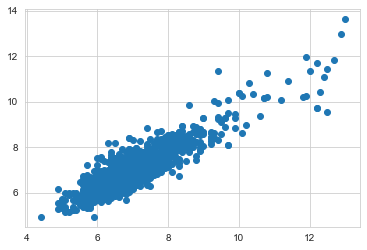

In [17]:
plt.scatter(ym1_test,predictions_m1)

**Residual Histogram**

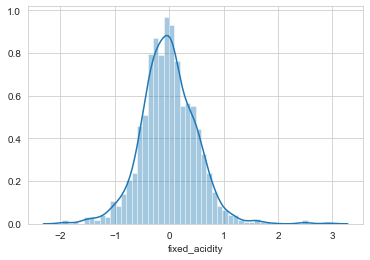

In [18]:
sns.distplot((ym1_test-predictions_m1),bins=50);

In [19]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym1_test, predictions_m1))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym1_test, predictions_m1))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym1_test, predictions_m1)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym1_test, predictions_m1))
print('Explained Variance:', metrics.explained_variance_score(ym1_test, predictions_m1))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym1_test, predictions_m1))
print('Median Absolute Error:', metrics.median_absolute_error(ym1_test, predictions_m1))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym1_test, predictions_m1))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym1_test, predictions_m1))



R-squared: 0.7911723852540985
Mean Squared Error (MSE): 0.2521680300182029
Root Mean Squared Error (RMSE): 0.5021633499352606
Log Mean Squared Error: 0.003623065142659646
Explained Variance: 0.7913342621710853
Mean Absolute Error (MAE): 0.37947513153347423
Median Absolute Error: 0.3107707017488339
Poisson Deviance: 0.033936685258461274
Mean Gamma Deviance: 0.004699613232009953


## Backward Elimination Method to create subsequent models

## Model 2 -  Drop Density Due to High VIF

In [20]:
ym2 = df.fixed_acidity
Xm2 = df.drop(['fixed_acidity','density'],axis=1)
from sklearn.model_selection import train_test_split
Xm2_train, Xm2_test, ym2_train, ym2_test = train_test_split(Xm2, ym2, test_size=0.25, random_state=101)
Xm2_train.head()

,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol
4418,0.21,0.34,2.0,0.042,63.0,123.0,3.44,0.42,11.40
5469,0.23,0.27,9.8,0.055,74.0,134.0,3.16,0.40,10.20
2236,0.28,0.25,11.9,0.053,25.0,148.0,3.10,0.62,9.20
6469,0.32,0.28,6.6,0.021,29.0,132.0,3.15,0.36,11.45
3477,0.25,0.26,14.0,0.043,41.0,248.0,3.03,0.57,8.70


In [21]:
from sklearn.linear_model import LinearRegression
lm2 = LinearRegression()
lm2.fit(Xm2_train,ym2_train)
print('Estimated intercept coefficient:',lm2.intercept_)
print ('Number of coefficients:', len(lm2.coef_))
coeffm2_df = pd.DataFrame(lm2.coef_,Xm2.columns,columns=['Coefficient'])
coeffm2_df

Estimated intercept coefficient: 12.903140140193122
Number of coefficients: 9


,Coefficient
volatile_acidity,1.072242
citric_acid,3.235079
residual_sugar,-0.013433
chlorides,19.774243
free_sulfur_dioxide,-0.006151
total_sulfur_dioxide,-0.002849
pH,-2.324187
sulphates,0.874988
alcohol,-0.048402


In [22]:
predictions_m2 = lm2.predict(Xm2_test)

**Predicted vs. Actual**

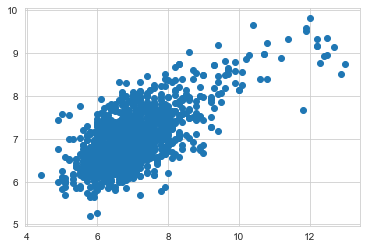

In [23]:
plt.scatter(ym2_test,predictions_m2)

**Residual Histogram**

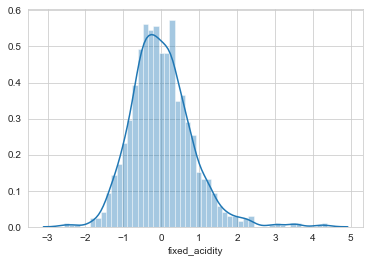

In [24]:
sns.distplot((ym2_test-predictions_m2),bins=50);

In [25]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym2_test, predictions_m2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym2_test, predictions_m2))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym2_test, predictions_m2)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym2_test, predictions_m2))
print('Explained Variance:', metrics.explained_variance_score(ym2_test, predictions_m2))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym2_test, predictions_m2))
print('Median Absolute Error:', metrics.median_absolute_error(ym2_test, predictions_m2))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym2_test, predictions_m2))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym2_test, predictions_m2))



R-squared: 0.45258199680343747
Mean Squared Error (MSE): 0.6610300061634196
Root Mean Squared Error (RMSE): 0.8130375182999979
Log Mean Squared Error: 0.009114295281697885
Explained Variance: 0.45264630370047865
Mean Absolute Error (MAE): 0.6127699887486777
Median Absolute Error: 0.4920234013260938
Poisson Deviance: 0.08749352278702163
Mean Gamma Deviance: 0.011900437906970051


## Model 3: Drop Total Sulfur Dioxide


In [26]:
ym3 = df.fixed_acidity
Xm3 = df.drop(['fixed_acidity','density','total_sulfur_dioxide'],axis=1)
from sklearn.model_selection import train_test_split
Xm3_train, Xm3_test, ym3_train, ym3_test = train_test_split(Xm3, ym3, test_size=0.25, random_state=101)
Xm3_train.head()

,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,pH,sulphates,alcohol
4418,0.21,0.34,2.0,0.042,63.0,3.44,0.42,11.40
5469,0.23,0.27,9.8,0.055,74.0,3.16,0.40,10.20
2236,0.28,0.25,11.9,0.053,25.0,3.10,0.62,9.20
6469,0.32,0.28,6.6,0.021,29.0,3.15,0.36,11.45
3477,0.25,0.26,14.0,0.043,41.0,3.03,0.57,8.70


In [27]:
Xm3_train.shape

(3720, 8)

In [28]:
from sklearn.linear_model import LinearRegression
lm3 = LinearRegression()
lm3.fit(Xm3_train,ym3_train)
print('Estimated intercept coefficient:',lm3.intercept_)
print ('Number of coefficients:', len(lm3.coef_))
coeffm1_df = pd.DataFrame(lm3.coef_,Xm3.columns,columns=['Coefficient'])
coeffm1_df

Estimated intercept coefficient: 12.336761824544432
Number of coefficients: 8


,Coefficient
volatile_acidity,1.051015
citric_acid,3.170612
residual_sugar,-0.017387
chlorides,21.859369
free_sulfur_dioxide,-0.011093
pH,-2.329272
sulphates,0.912214
alcohol,-0.018264


In [29]:
predictions_m3 = lm3.predict(Xm3_test)

**Predicted vs. Actual**

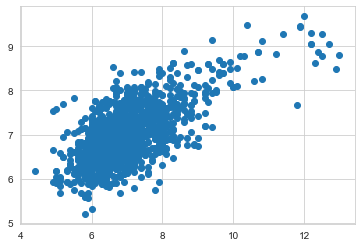

In [30]:
plt.scatter(ym3_test,predictions_m3)

**Residual Histogram**

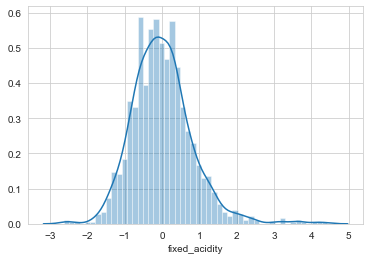

In [31]:
sns.distplot((ym3_test-predictions_m3),bins=50);

In [32]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym3_test, predictions_m3))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym3_test, predictions_m3))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym3_test, predictions_m3)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym3_test, predictions_m3))
print('Explained Variance:', metrics.explained_variance_score(ym3_test, predictions_m3))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym3_test, predictions_m3))
print('Median Absolute Error:', metrics.median_absolute_error(ym3_test, predictions_m3))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym3_test, predictions_m3))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym3_test, predictions_m3))



R-squared: 0.4408394109991284
Mean Squared Error (MSE): 0.6752096669003167
Root Mean Squared Error (RMSE): 0.8217114255627195
Log Mean Squared Error: 0.009253959322428352
Explained Variance: 0.4409077995779298
Mean Absolute Error (MAE): 0.6144033949010483
Median Absolute Error: 0.495371246263395
Poisson Deviance: 0.08909240107162182
Mean Gamma Deviance: 0.012079210529485795


## Model 4: Drop Free Sulfur Dioxide

In [33]:
ym4 = df.fixed_acidity
Xm4 = df.drop(['fixed_acidity','density','total_sulfur_dioxide','free_sulfur_dioxide'],axis=1)
from sklearn.model_selection import train_test_split
Xm4_train, Xm4_test, ym4_train, ym4_test = train_test_split(Xm4, ym4, test_size=0.25, random_state=101)
Xm4_train.head()


,volatile_acidity,citric_acid,residual_sugar,chlorides,pH,sulphates,alcohol
4418,0.21,0.34,2.0,0.042,3.44,0.42,11.40
5469,0.23,0.27,9.8,0.055,3.16,0.40,10.20
2236,0.28,0.25,11.9,0.053,3.10,0.62,9.20
6469,0.32,0.28,6.6,0.021,3.15,0.36,11.45
3477,0.25,0.26,14.0,0.043,3.03,0.57,8.70


In [34]:
Xm4_train.shape

(3720, 7)

In [35]:
lm4 = LinearRegression()
lm4.fit(Xm4_train,ym4_train)
print('Estimated intercept coefficient:',lm4.intercept_)
print ('Number of coefficients:', len(lm4.coef_))
coeffm4_df = pd.DataFrame(lm4.coef_,Xm4.columns,columns=['Coefficient'])
coeffm4_df

Estimated intercept coefficient: 11.892980481198828
Number of coefficients: 7


,Coefficient
volatile_acidity,1.285340
citric_acid,3.119290
residual_sugar,-0.030111
chlorides,23.827168
pH,-2.391189
sulphates,0.928345
alcohol,0.001422


In [36]:
predictions_m4 = lm4.predict(Xm4_test)

**Predicted vs. Actual**

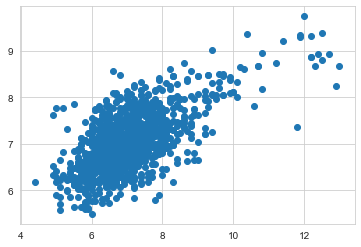

In [37]:
plt.scatter(ym1_test,predictions_m4)

**Residual Histogram**

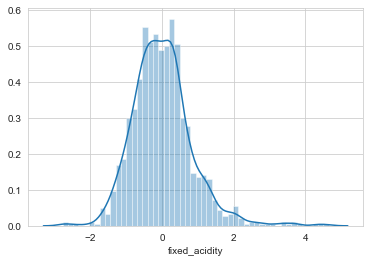

In [38]:
sns.distplot((ym4_test-predictions_m4),bins=50);

In [39]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym4_test, predictions_m4))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym4_test, predictions_m4))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym4_test, predictions_m4)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym4_test, predictions_m4))
print('Explained Variance:', metrics.explained_variance_score(ym4_test, predictions_m4))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym4_test, predictions_m4))
print('Median Absolute Error:', metrics.median_absolute_error(ym4_test, predictions_m4))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym4_test, predictions_m4))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym4_test, predictions_m4))

R-squared: 0.41722357827943357
Mean Squared Error (MSE): 0.7037267670999766
Root Mean Squared Error (RMSE): 0.8388842393918106
Log Mean Squared Error: 0.009586497892233512
Explained Variance: 0.4173519868013724
Mean Absolute Error (MAE): 0.6240963901231884
Median Absolute Error: 0.485427112284456
Poisson Deviance: 0.09262498233055919
Mean Gamma Deviance: 0.012517635048998735


## Model 5: Drop Residual Sugar


In [40]:
ym5 = df.fixed_acidity
Xm5 = df.drop(['fixed_acidity','density','total_sulfur_dioxide','free_sulfur_dioxide','residual_sugar'],axis=1)
from sklearn.model_selection import train_test_split
Xm5_train, Xm5_test, ym5_train, ym5_test = train_test_split(Xm5, ym5, test_size=0.25, random_state=101)
Xm5_train.head()




,volatile_acidity,citric_acid,chlorides,pH,sulphates,alcohol
4418,0.21,0.34,0.042,3.44,0.42,11.40
5469,0.23,0.27,0.055,3.16,0.40,10.20
2236,0.28,0.25,0.053,3.10,0.62,9.20
6469,0.32,0.28,0.021,3.15,0.36,11.45
3477,0.25,0.26,0.043,3.03,0.57,8.70


In [41]:
Xm5_train.shape

(3720, 6)

In [42]:
from sklearn.linear_model import LinearRegression
lm5 = LinearRegression()
lm5.fit(Xm5_train,ym5_train)
print('Estimated intercept coefficient:',lm5.intercept_)
print ('Number of coefficients:', len(lm5.coef_))
coeffm5_df = pd.DataFrame(lm5.coef_,Xm5.columns,columns=['Coefficient'])
coeffm5_df

Estimated intercept coefficient: 10.609729062077658
Number of coefficients: 6


,Coefficient
volatile_acidity,1.256679
citric_acid,3.057363
chlorides,25.429544
pH,-2.252920
sulphates,1.009784
alcohol,0.056439


In [43]:
predictions_m5 = lm5.predict(Xm5_test)

**Predicted vs. Actual**

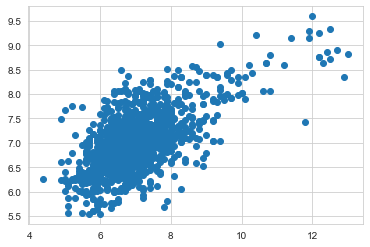

In [44]:
plt.scatter(ym5_test,predictions_m5)

**Residual Histogram**

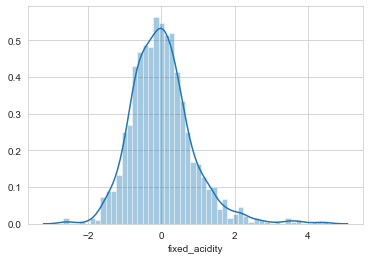

In [45]:
sns.distplot((ym5_test-predictions_m5),bins=50);

In [46]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym5_test, predictions_m5))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym5_test, predictions_m5))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym5_test, predictions_m5)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym5_test, predictions_m5))
print('Explained Variance:', metrics.explained_variance_score(ym5_test, predictions_m5))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym5_test, predictions_m5))
print('Median Absolute Error:', metrics.median_absolute_error(ym5_test, predictions_m5))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym5_test, predictions_m5))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym5_test, predictions_m5))



R-squared: 0.40394213444688787
Mean Squared Error (MSE): 0.7197646629076055
Root Mean Squared Error (RMSE): 0.8483894523788031
Log Mean Squared Error: 0.009766794547222754
Explained Variance: 0.4040653542260483
Mean Absolute Error (MAE): 0.6280025930512373
Median Absolute Error: 0.4940268309031399
Poisson Deviance: 0.09462315968028032
Mean Gamma Deviance: 0.012769833650648833



## Model 6: Drop Alcohol



In [47]:
ym6 = df.fixed_acidity
Xm6 = df.drop(['fixed_acidity','density','total_sulfur_dioxide','free_sulfur_dioxide','residual_sugar','alcohol'],axis=1)
from sklearn.model_selection import train_test_split
Xm6_train, Xm6_test, ym6_train, ym6_test = train_test_split(Xm6, ym6, test_size=0.25, random_state=101)
Xm6_train.head()


,volatile_acidity,citric_acid,chlorides,pH,sulphates
4418,0.21,0.34,0.042,3.44,0.42
5469,0.23,0.27,0.055,3.16,0.40
2236,0.28,0.25,0.053,3.10,0.62
6469,0.32,0.28,0.021,3.15,0.36
3477,0.25,0.26,0.043,3.03,0.57


In [48]:
Xm6_train.shape

(3720, 5)

In [49]:
from sklearn.linear_model import LinearRegression
lm6 = LinearRegression()
lm6.fit(Xm6_train,ym6_train)
print('Estimated intercept coefficient:',lm6.intercept_)
print ('Number of coefficients:', len(lm6.coef_))
coeffm6_df = pd.DataFrame(lm6.coef_,Xm6.columns,columns=['Coefficient'])
coeffm6_df


Estimated intercept coefficient: 11.06057806345548
Number of coefficients: 5


,Coefficient
volatile_acidity,1.387135
citric_acid,3.101052
chlorides,22.882205
pH,-2.193620
sulphates,1.052528


In [50]:
predictions_m6 = lm6.predict(Xm6_test)

**Predicted vs. Actual**

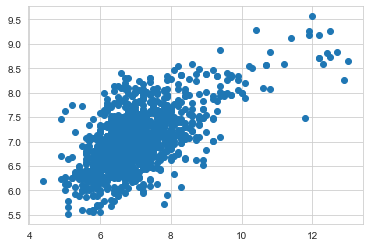

In [51]:
plt.scatter(ym6_test,predictions_m6)

**Residual Histogram**

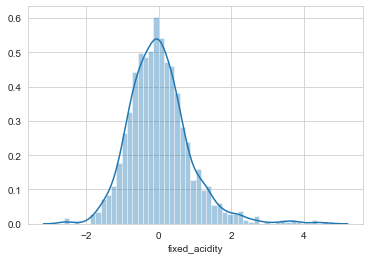

In [52]:
sns.distplot((ym6_test-predictions_m6),bins=50);

In [53]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym6_test, predictions_m6))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym6_test, predictions_m6))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym6_test, predictions_m6)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym6_test, predictions_m6))
print('Explained Variance:', metrics.explained_variance_score(ym6_test, predictions_m6))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym6_test, predictions_m6))
print('Median Absolute Error:', metrics.median_absolute_error(ym6_test, predictions_m6))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym6_test, predictions_m6))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym6_test, predictions_m6))



R-squared: 0.3994829134718826
Mean Squared Error (MSE): 0.725149357695463
Root Mean Squared Error (RMSE): 0.8515570196384168
Log Mean Squared Error: 0.009799800440158903
Explained Variance: 0.3995567324190227
Mean Absolute Error (MAE): 0.6286550345525361
Median Absolute Error: 0.49151179611907203
Poisson Deviance: 0.0951183873708895
Mean Gamma Deviance: 0.01280523182220668


## Model 7: Drop Sulphates

In [54]:
ym7 = df.fixed_acidity
Xm7 = df.drop(['fixed_acidity','density','total_sulfur_dioxide','free_sulfur_dioxide','residual_sugar','alcohol','sulphates'],axis=1)
from sklearn.model_selection import train_test_split
Xm7_train, Xm7_test, ym7_train, ym7_test = train_test_split(Xm7, ym7, test_size=0.25, random_state=101)
Xm7_train.head()


,volatile_acidity,citric_acid,chlorides,pH
4418,0.21,0.34,0.042,3.44
5469,0.23,0.27,0.055,3.16
2236,0.28,0.25,0.053,3.10
6469,0.32,0.28,0.021,3.15
3477,0.25,0.26,0.043,3.03


In [55]:
Xm7_train.shape

(3720, 4)

In [56]:
from sklearn.linear_model import LinearRegression
lm7 = LinearRegression()
lm7.fit(Xm7_train,ym7_train)
print('Estimated intercept coefficient:',lm7.intercept_)
print ('Number of coefficients:', len(lm7.coef_))
coeffm7_df = pd.DataFrame(lm7.coef_,Xm7.columns,columns=['Coefficient'])
coeffm7_df

Estimated intercept coefficient: 10.898421757040413
Number of coefficients: 4


,Coefficient
volatile_acidity,1.466386
citric_acid,3.243626
chlorides,24.958787
pH,-2.030355


In [57]:
predictions_m7 = lm7.predict(Xm7_test)

**Predicted vs. Actual**

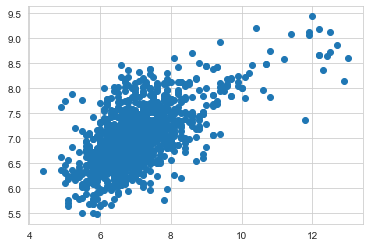

In [58]:
plt.scatter(ym7_test,predictions_m7)

**Residual Histogram**

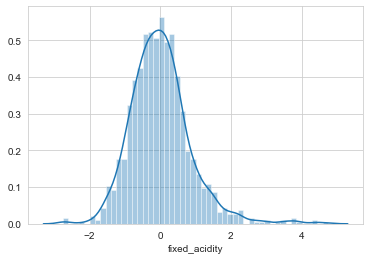

In [59]:
sns.distplot((ym7_test-predictions_m7),bins=50);

In [60]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym7_test, predictions_m7))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym7_test, predictions_m7))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym7_test, predictions_m7)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym7_test, predictions_m7))
print('Explained Variance:', metrics.explained_variance_score(ym7_test, predictions_m7))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym7_test, predictions_m7))
print('Median Absolute Error:', metrics.median_absolute_error(ym7_test, predictions_m7))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym7_test, predictions_m7))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym7_test, predictions_m7))


R-squared: 0.3871475740107815
Mean Squared Error (MSE): 0.7400447931257655
Root Mean Squared Error (RMSE): 0.8602585617857956
Log Mean Squared Error: 0.009968867460956219
Explained Variance: 0.38727318581615244
Mean Absolute Error (MAE): 0.6334557652387366
Median Absolute Error: 0.49461203497810846
Poisson Deviance: 0.09690153723038514
Mean Gamma Deviance: 0.013019985517239051


## Model 8: Drop Volatile Acidity

In [61]:
ym8 = df.fixed_acidity
Xm8 = df.drop(['fixed_acidity','density','total_sulfur_dioxide','free_sulfur_dioxide','residual_sugar','alcohol','sulphates','volatile_acidity'],axis=1)
from sklearn.model_selection import train_test_split
Xm8_train, Xm8_test, ym8_train, ym8_test = train_test_split(Xm8, ym8, test_size=0.25, random_state=101)
Xm8_train.head()

,citric_acid,chlorides,pH
4418,0.34,0.042,3.44
5469,0.27,0.055,3.16
2236,0.25,0.053,3.10
6469,0.28,0.021,3.15
3477,0.26,0.043,3.03


In [62]:
Xm8_train.shape

(3720, 3)

In [63]:
from sklearn.linear_model import LinearRegression
lm8 = LinearRegression()
lm8.fit(Xm8_train,ym8_train)
print('Estimated intercept coefficient:',lm8.intercept_)
print ('Number of coefficients:', len(lm8.coef_))
coeffm8_df = pd.DataFrame(lm8.coef_,Xm8.columns,columns=['Coefficient'])
coeffm8_df

Estimated intercept coefficient: 11.0877931937039
Number of coefficients: 3


,Coefficient
citric_acid,2.890278
chlorides,28.814641
pH,-1.975240


In [64]:
predictions_m8 = lm8.predict(Xm8_test)

**Predicted vs. Actual**

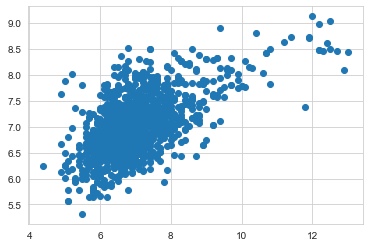

In [65]:
plt.scatter(ym8_test,predictions_m8)

**Residual Histogram**

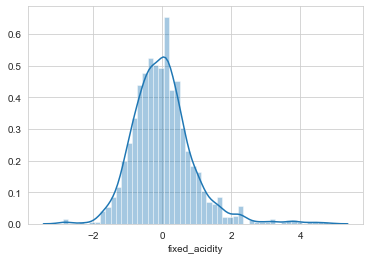

In [66]:
sns.distplot((ym8_test-predictions_m8),bins=50);

In [67]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym8_test, predictions_m8))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym8_test, predictions_m8))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym8_test, predictions_m8)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym8_test, predictions_m8))
print('Explained Variance:', metrics.explained_variance_score(ym8_test, predictions_m8))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym8_test, predictions_m8))
print('Median Absolute Error:', metrics.median_absolute_error(ym8_test, predictions_m8))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym8_test, predictions_m8))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym8_test, predictions_m8))


R-squared: 0.36204009066914455
Mean Squared Error (MSE): 0.7703631234896844
Root Mean Squared Error (RMSE): 0.8777033231620377
Log Mean Squared Error: 0.010282444760123893
Explained Variance: 0.3621885161086068
Mean Absolute Error (MAE): 0.6413429908780637
Median Absolute Error: 0.4877769609822131
Poisson Deviance: 0.10048256824030133
Mean Gamma Deviance: 0.013440023842538708


## Model 9: Drop pH

In [68]:
ym9 = df.fixed_acidity
Xm9 = df.drop(['fixed_acidity','density','total_sulfur_dioxide','free_sulfur_dioxide','residual_sugar','alcohol','sulphates','volatile_acidity','pH'],axis=1)
from sklearn.model_selection import train_test_split
Xm9_train, Xm9_test, ym9_train, ym9_test = train_test_split(Xm9, ym9, test_size=0.25, random_state=101)
Xm9_train.head()


,citric_acid,chlorides
4418,0.34,0.042
5469,0.27,0.055
2236,0.25,0.053
6469,0.28,0.021
3477,0.26,0.043


In [69]:
Xm9_train.shape

(3720, 2)

In [70]:
from sklearn.linear_model import LinearRegression
lm9 = LinearRegression()
lm9.fit(Xm9_train,ym9_train)
print('Estimated intercept coefficient:',lm9.intercept_)
print ('Number of coefficients:', len(lm9.coef_))
coeffm9_df = pd.DataFrame(lm9.coef_,Xm9.columns,columns=['Coefficient'])
coeffm9_df


Estimated intercept coefficient: 4.749635026079684
Number of coefficients: 2


,Coefficient
citric_acid,3.378487
chlorides,25.580412


In [71]:
predictions_m9 = lm9.predict(Xm9_test)

**Predicted vs. Actual**

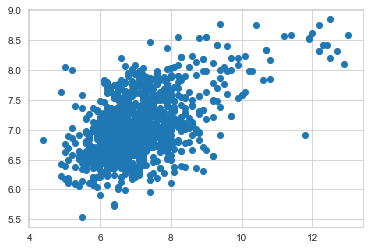

In [72]:
plt.scatter(ym9_test,predictions_m9)

**Residual Histogram**

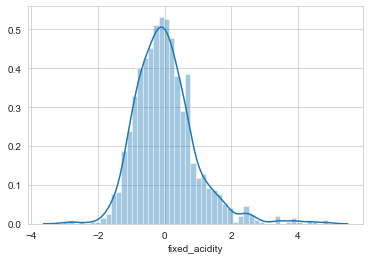

In [73]:
sns.distplot((ym9_test-predictions_m9),bins=50);

In [74]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym9_test, predictions_m9))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym9_test, predictions_m9))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym9_test, predictions_m9)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym9_test, predictions_m9))
print('Explained Variance:', metrics.explained_variance_score(ym9_test, predictions_m9))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym9_test, predictions_m9))
print('Median Absolute Error:', metrics.median_absolute_error(ym9_test, predictions_m9))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym9_test, predictions_m9))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym9_test, predictions_m9))


R-squared: 0.28897427215919314
Mean Squared Error (MSE): 0.8585931381730447
Root Mean Squared Error (RMSE): 0.9266030100172591
Log Mean Squared Error: 0.011626278435715821
Explained Variance: 0.2891909672048376
Mean Absolute Error (MAE): 0.6776626384774278
Median Absolute Error: 0.5292389413396776
Poisson Deviance: 0.11321514329860732
Mean Gamma Deviance: 0.015291757622232576


## Model 10: Citric Acid

In [75]:
ym10 = df.fixed_acidity
Xm10 = df.drop(['fixed_acidity','density','total_sulfur_dioxide','free_sulfur_dioxide','residual_sugar','alcohol','sulphates','volatile_acidity','pH','citric_acid'],axis=1)
from sklearn.model_selection import train_test_split
Xm10_train, Xm10_test, ym10_train, ym10_test = train_test_split(Xm10, ym10, test_size=0.25, random_state=101)
Xm10_train.head()


,chlorides
4418,0.042
5469,0.055
2236,0.053
6469,0.021
3477,0.043


In [76]:
Xm10_train.shape

(3720, 1)

In [77]:
from sklearn.linear_model import LinearRegression
lm10 = LinearRegression()
lm10.fit(Xm10_train,ym10_train)
print('Estimated intercept coefficient:',lm10.intercept_)
print ('Number of coefficients:', len(lm10.coef_))
coeffm10_df = pd.DataFrame(lm10.coef_,Xm10.columns,columns=['Coefficient'])
coeffm10_df

Estimated intercept coefficient: 5.889368798877525
Number of coefficients: 1


,Coefficient
chlorides,24.54218


In [78]:
predictions_m10 = lm10.predict(Xm10_test)

**Predicted vs. Actual**

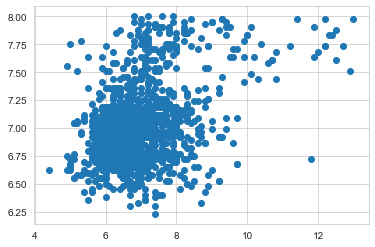

In [79]:
plt.scatter(ym10_test,predictions_m10)

**Residual Histogram**

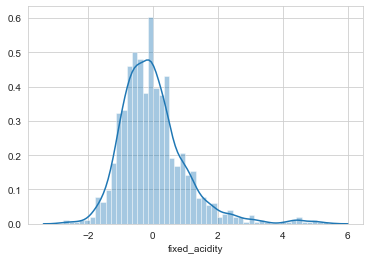

In [80]:
sns.distplot((ym10_test-predictions_m10),bins=50);

In [81]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym10_test, predictions_m10))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym10_test, predictions_m10))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym10_test, predictions_m10)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym10_test, predictions_m10))
print('Explained Variance:', metrics.explained_variance_score(ym10_test, predictions_m10))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym10_test, predictions_m10))
print('Median Absolute Error:', metrics.median_absolute_error(ym10_test, predictions_m10))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym10_test, predictions_m10))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym10_test, predictions_m10))

R-squared: 0.1343999017034485
Mean Squared Error (MSE): 1.0452481192997398
Root Mean Squared Error (RMSE): 1.0223737669266264
Log Mean Squared Error: 0.014042663883628516
Explained Variance: 0.1344483971343171
Mean Absolute Error (MAE): 0.7385410822541699
Median Absolute Error: 0.5710559809622531
Poisson Deviance: 0.1381960061156445
Mean Gamma Deviance: 0.018658316112385172
